# Graph Overflow

Group 5

- Asger Laurits Schultz
- August Semrau Andersen
- Andreas Hornemann Nielsen

Asger wrote the data download script and preprocessing.
Sentiment analysis, TF-IDF, classification, and the network partitioning using the classifier was also done by Asger.  
August did the entire network analysis part and was responsible for data integrity.
Andreas was responsible for writing introduction and most of the discussion and did initial work on sentiment analysis.

The discussion was written equally by August and Andreas.
All parts were reviewed by all group members.

The website graphs and interactive elements were developed by Asger, but the static content was provided relatively evenly by all group members.

## Table of contents

- 1. Motivation
- 2. Data
- 3. Analysis
    - 3.1. Stack Overflow as a Graph
    - 3.2. Sentiment Analysis and Loved Languages
    - 3.3. Building a Language Classifier Using TF-IDF
    - 3.4. Using the Classifier to Partition the Graph
- 4. Discussion

## 1. Motivation and Dataset

Our goal is to get an insight into Stack Overflow and how strongly the programming languages divide users, and what differences there exist between such communities.

To do so, we perform network analysis as well as visualising network structures and investigating modularity.
We also do sentiment analysis and use TF-IDF to find important words for each programming language and then use that for building a classifier that predicts a programming language from a piece of text.

#### The dataset
Our dataset consists of 1.3 million submissions from Stack Overflow.
Each submission is either a question, an answer, or a comment on either an answer or a question.
They are also tagged with one of 16 widely used programming languages: Rust, TypeScript, Python, Kotlin, Go, Dart, C#, JavaScript, Haskell, Java, C++, Ruby, C, Perl, Objective-C, and VBA.

For each language, we have queried up to 100 threads (with each thread consisting of a question and a number of answers and comments) per week in the period 2015-2019.
Due to this, our data is roughly uniform over this period, with less data from 2020 and 2021, as this is only comments and answers on questions asked in 2019 or earlier.

For each submission, we save data on the parent author (if relevant), the author, the content, the language, the question id, and the type of submission.

#### The choice of dataset

Our dataset had help achieve our goals while being easily obtainable and having the necessary features.
The described dataset was relatively easy to download and had a large amount of both user interactions and text for each user and programming language.

#### Our goal

As part of this project and our scope, we focus on creating a nice and beautiful overview of our findings on a website, including interactive graphs and good data visualization allowing for the best experience.
A key feature for our website is the interactive plots and classifiers, allowing the user to play with some of the major results from our analysis.

As well as a website, the complete notebook is attached with all our code and comments to guide the user, showing off all parts of our project, data gathering, computation, analyses and visualizations.

## 2. Data and Data Preparation

Our data consists of a subset of Stack Overflow threads created from 2015 to 2019.
We have selected the following 16 widely used programming languages to focus on: 

For each week in the period, we download up to 100 threads for each language including the question itself, all answers, and all comments, as well as information about the authors.
This also means that some of the answers and comments will extend past 2019.
The data is collected using the <a href="https://pypi.org/project/stackapi">StackAPI</a> wrapper for the <a href="https://api.stackexchange.com/">Stack Excange API</a>.
Due to throttling limitations, the data was downloaded over multiple days using the following script.
This should give a representative sample within each language.

In [2]:
%%script false --no-raise-error
from __future__ import annotations
import os
import sys
import datetime as dt
import json
import math
from typing import Any

import click
import pandas as pd
import stackapi
from pelutils import log, Levels
from tqdm import tqdm

# Fetch data from five years
DAY_INTERVAL = 7
START_DATE = dt.datetime(2015, 1, 1)
END_DATE = dt.datetime(2020, 1, 1)

SITE = stackapi.StackAPI("stackoverflow")
SITE.max_pages = 1
N_REQUESTS = math.ceil((END_DATE - START_DATE).days / DAY_INTERVAL)
assert N_REQUESTS < 300

def _get_by_nested_keys(d: dict, keys: list[str]) -> tuple[str, Any]:
    if len(keys) == 1:
        return d.get(keys[0])
    else:
        return _get_by_nested_keys(d[keys[0]], keys[1:])

def get_data(language: str) -> pd.DataFrame:

    os.makedirs(os.path.join("data", language), exist_ok=True)
    log.section("Getting data for %s from %s to %s" % (language, START_DATE.date(), END_DATE.date()-dt.timedelta(days=1)))
    log("Using %i requests" % N_REQUESTS)
    quota_remaing = 300
    questions = list()

    start, end = START_DATE, START_DATE + dt.timedelta(days=DAY_INTERVAL)
    for i in tqdm(range(N_REQUESTS)):
        r = SITE.fetch(
            "questions",
            fromdate=start,
            todate=end,
            tagged=language,
            sort="creation",
            filter="!)PBt)ZX9Bm(JUgw*DM)sjdIE*XsapktUmLzYx2hZO*0Ucza8VQCedEvwmjgs5h_VvaGrwX",
        )
        quota_remaing = r["quota_remaining"]
        questions += r["items"]
        # Save fetched data
        with open(os.path.join("data", language, "response_%i.json" % i), "w") as f:
            json.dump(r["items"], f)

        start += dt.timedelta(days=DAY_INTERVAL)
        end += dt.timedelta(days=DAY_INTERVAL)
        if start >= END_DATE:
            break
        elif end > END_DATE:
            end = END_DATE

    log("Got %i responses" % len(questions), "Remaining quota: %i" % quota_remaing)

    # Save useful things from response
    log.section("Extracting useful data")
    useful_question_keys = { "title", "body", "view_count", "score", "creation_date", "link",
        "question_id", "owner/user_id", "owner/reputation" }
    useful_answer_keys = { "body", "creation_date", "score", "owner/user_id", "owner/reputation", "answer_id" }
    useful_comment_keys = useful_answer_keys
    filtered_questions, filtered_answers, filtered_comments = list(), list(), list()
    for _, q in tqdm(enumerate(questions)):
        filtered_questions.append({
            "language": language,
            **{ key: str(_get_by_nested_keys(q, key.split("/"))) for key in useful_question_keys if key in q or "/" in key }
        })
        for answer in q.get("answers", list()):
            filtered_answers.append({
                "language": language,
                "question_id": str(q["question_id"]),
                **{ key: str(_get_by_nested_keys(answer, key.split("/"))) for key in useful_answer_keys if key in answer or "/" in key }
            })
            for comment in answer.get("comments", list()):
                filtered_comments.append({
                    "language": language,
                    "question_id": str(q["question_id"]),
                    "answer_id": str(answer["answer_id"]),
                    **{ key: str(_get_by_nested_keys(comment, key.split("/"))) for key in useful_comment_keys if key in comment or "/" in key },
                })
        for comment in q.get("comments", list()):
            filtered_comments.append({
                "language": language,
                "question_id": str(q["question_id"]),
                **{ key: str(_get_by_nested_keys(comment, key.split("/"))) for key in useful_comment_keys if key in comment or "/" in key },
            })

    df = pd.DataFrame(filtered_questions)
    q_path = os.path.join("data", language, "questions.pkl")
    df.to_pickle(q_path)
    log("Saved %i questions to %s" % (len(df), q_path))
    del df

    df = pd.DataFrame(filtered_answers)
    a_path = os.path.join("data", language, "answers.pkl")
    df.to_pickle(a_path)
    log("Saved %i answers to %s" % (len(df), a_path))
    del df

    df = pd.DataFrame(filtered_comments)
    c_path = os.path.join("data", language, "comments.pkl")
    df.to_pickle(c_path)
    log("Saved %i comments to %s" % (len(df), c_path))
    del df

@click.command()
@click.argument("language")
def run(language: str):
    path = os.path.join("data", "%s-questions.pkl" % language)
    if os.path.exists(path):
        cont = log.bool_input(log.input("%s eksisterer allerede. Vil du fortsætte alligevel? [j/n] " % path), default=False)
        if not cont:
            sys.exit()
    get_data(language.lower())

if __name__ == "__main__":
    with log.log_errors:
        log.configure("local_data.log", "Fetching data", print_level=Levels.DEBUG)
        run()

The downloaded data is then converted into a single, large dataframe containing all submissions.
Because of the large amount of data, half is removed, as memory would otherwise be a serious constraint.
This is done by thread basis.
Half of all question ID's are randomly selected, and submissions with that ID are removed.

In [2]:
from __future__ import annotations
import os
import pandas as pd
import vaderSentiment.vaderSentiment as vader
import re
from glob import glob as glob  # glob
from tqdm import tqdm
from pelutils import Table, thousand_seps
from pelutils.ds.plot import tab_colours
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.metrics import f1_score
import datetime as dt
import itertools
import random
import json
import pickle
import scipy
import networkx as nx
import netwulf as nf
import community as cm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rc("font", size=16)
mpl.rcParams["font.family"] = "Liberation Serif"
import warnings
warnings.filterwarnings('ignore')
impath = lambda x: os.path.join("website", "src", "assets", x + ".png")

# Selected language and how loved they were according to the 2020 Stack Overflow developer survey
loved_languages = {
    "rust": 86.1, "typescript": 67.1, "python": 66.7, "kotlin": 62.9, "go": 62.3, "dart": 62.1,
    "c#": 59.7, "javascript":  58.3, "haskell": 51.7, "java": 44.1, "c++": 43.4, "ruby": 42.9,
    "c": 33.1, "perl": 28.6, "objective-c": 23.4, "vba": 19.6,
}
# Which colours to use for the different languages
language_colors = {
    "rust": 'peru', "typescript": 'navy', "python": 'cyan', "kotlin": 'azure', "go": 'moccasin', "dart": 'maroon',
    "c#": 'purple', "javascript": 'yellow', "haskell": 'black', "java": 'green', "c++": 'red', "ruby": 'olive',
    "c": 'pink', "perl": 'magenta', "objective-c": 'lime', "vba": 'orange',
}

In [2]:
# Collect all data into single dataframe
qdfs = list()
adfs = list()
cdfs = list()
for lang in loved_languages:
    qf = os.path.join("data", lang, "questions.pkl")
    af = os.path.join("data", lang, "answers.pkl")
    cf = os.path.join("data", lang, "comments.pkl")
    qdfs.append(pd.read_pickle(qf))
    qdfs[-1]["language"] = lang
    qdfs[-1]["type"] = "q"
    adfs.append(pd.read_pickle(af))
    adfs[-1]["language"] = lang
    adfs[-1]["type"] = "a"
    cdfs.append(pd.read_pickle(cf))
    cdfs[-1]["language"] = lang
    cdfs[-1]["type"] = "c"

# Shuffle to prevent systematic biases in contiguous subsets of dataframe
so = pd.concat(qdfs + adfs + cdfs, ignore_index=True).sample(frac=1)
del qdfs, adfs, cdfs

# Remove half of data, as there is otherwise too much to handle
qids = { qid for i, qid in enumerate(sorted(set(so.question_id))) if i % 2 }
so = so[so.question_id.isin(qids)]
# Convert unix timestamps to datetime objects
so["created"] = [dt.datetime.utcfromtimestamp(int(ts)) for ts in so["creation_date"]]
del so["creation_date"], so["title"], so["view_count"], so["score"], so["owner/reputation"]

In [3]:
# Data summary
t = Table()
t.add_header(["Language", "Questions", "Answers", "Comments", "Total"])
for lang in loved_languages:
    t.add_row([
        lang.capitalize(),
        *[thousand_seps(sum((so["language"] == lang) & (so["type"] == t))) for t in ("q", "a", "c")],
        thousand_seps(sum(so["language"] == lang)),
    ], [1, 0, 0, 0, 0])
t.add_row([
    "",
    thousand_seps(sum(so["type"] == "q")),
    thousand_seps(sum(so["type"] == "a")),
    thousand_seps(sum(so["type"] == "c")),
    thousand_seps(len(so)),
], [1, 0, 0, 0, 0])
print("Number of submissions in dataset")
print(t)
print("\nNumber of users in dataset")
print(thousand_seps(len(set(so["owner/user_id"]))))

Number of submissions in dataset
Language    | Questions | Answers | Comments | Total    
------------+-----------+---------+----------+----------
Rust        |     6,590 |   8,047 |   25,323 |    39,960
Typescript  |    11,937 |  17,462 |   45,631 |    75,030
Python      |    13,020 |  18,100 |   51,786 |    82,906
Kotlin      |     8,075 |  12,707 |   30,155 |    50,937
Go          |    12,903 |  17,200 |   46,723 |    76,826
Dart        |     6,053 |   9,892 |   21,178 |    37,123
C#          |    13,134 |  16,521 |   60,469 |    90,124
Javascript  |    12,966 |  18,076 |   53,662 |    84,704
Haskell     |    10,912 |  15,138 |   51,103 |    77,153
Java        |    13,207 |  17,300 |   55,463 |    85,970
C++         |    12,958 |  17,600 |   81,424 |   111,982
Ruby        |    13,086 |  18,062 |   52,905 |    84,053
C           |    13,013 |  20,022 |   95,077 |   128,112
Perl        |     9,818 |  15,546 |   54,388 |    79,752
Objective-c |    11,931 |  14,641 |   48,737 |    75,30

With the data nicely collected, we clean it.
As we need it for different purposes, this is done in two different ways for the sentiment analysis and classifier that will be introduced in later sections.
The text bodies are raw HTML, so tags (but not their contents) are removed.
Stopwords and links are also removed.

For the sentiment analysis, we remove all code, as code is not expected to carry sentiment.
This is not done for the classifier, as keywords and naming conventions should provide strong classification features.
However, all non alphanumeric characters are removed, as this is not expected to aid in classification.
These characters are kept for the sentiment analysis, as <a href="https://pypi.org/project/vader-sentiment/">VADER</a>, the used sentiment analysis tool, takes punctuation into account.
For the classifier, we all text is also converted to lower case.

In [4]:
# Regex for matching stopwords
sw = r"\b(" + "|".join(stopwords.words("english")) + r")\b"

def cclean(text: str) -> str:
    """ Cleaning for classification """
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    # Remove everything that is not alpha-numeric
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower()

def sclean(text: str) -> str:
    """ Cleaning for sentiment analysis """
    # Remove code
    text = re.sub(r"<pre><code>.*<\/pre><\/code>", "", text)
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    return text

words = sum(len(body.split()) for body in so.body)
chars = sum(len(body) for body in so.body)
print("Before cleaning")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

print("\nCleaning text for classification")
so["cclean"] = [cclean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.cclean)
chars = sum(len(body) for body in so.cclean)
print("\nAfter cleaning for classification")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

print("\nCleaning text for sentiment analysis")
so["sclean"] = [sclean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.sclean)
chars = sum(len(body) for body in so.sclean)
print("\nAfter cleaning for classification")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

# Save prepared data for later use
so.to_pickle("data.pkl")

  0%|          | 993/1272553 [00:00<02:08, 9922.51it/s]

Before cleaning
  Words:               86,146,292
  Avg. per submission: 67.70
  Characters:          705,213,176
  Avg. per submission: 554.17

Cleaning text for classification


  0%|          | 1141/1272553 [00:00<01:51, 11373.03it/s]


After cleaning for classification
  Words:               51,583,020
  Avg. per submission: 40.54
  Characters:          473,881,472
  Avg. per submission: 372.39

Cleaning text for sentiment analysis


100%|██████████| 1272553/1272553 [01:42<00:00, 12453.49it/s]



After cleaning for classification
  Words:               58,642,531
  Avg. per submission: 46.08
  Characters:          531,028,636
  Avg. per submission: 417.29


In [5]:
if "so" not in locals():
    so = pd.read_pickle("data.pkl")
so

,language,question_id,owner/user_id,link,body,type,answer_id,created,cclean,sclean
1108909,python,58000663,2690677,NaN,I just updated the code snippet to include the...,c,NaN,2019-09-19 16:55:31,i updated code snippet include import ray ...,I updated code snippet include import ray ...
1814488,c++,41857493,7344905,NaN,"Thanks for sharing your idea. Actually, we wan...",c,41857713,2017-01-25 17:31:16,thanks sharing idea actually want use 39li...,"Thanks sharing idea. Actually, want use &#..."
150597,javascript,37309939,None,https://stackoverflow.com/questions/37309939/l...,<p><strong>My problem:</strong></p>\n\n<p>Ever...,q,NaN,2016-05-18 20:54:41,my problem\n\neverything appearing within vi...,My problem:\n\nEverything appearing within v...
1834922,c++,46207616,65863,NaN,Drag&amp;Drop between windows is implemented u...,c,NaN,2017-09-13 22:51:11,dragampdrop windows implemented using idrag...,Drag&amp;Drop windows implemented using IDr...
119996,c#,31302120,3096390,https://stackoverflow.com/questions/31302120/m...,<p>I'm trying to edit data though angularjs an...,q,NaN,2015-07-08 19:36:59,i trying edit data though angularjs i got ...,I' trying edit data though angularjs I' got ...
...,...,...,...,...,...,...,...,...,...,...
1351662,c#,39623551,955076,NaN,it&#39;s hard to tell when you don&#39;t show ...,c,NaN,2016-09-21 18:29:41,39 hard tell 39 show code event code d...,&#39; hard tell &#39; show code Event Co...
781295,perl,31112948,4248931,NaN,<p>This will give list of all files name which...,a,31113642,2015-06-29 10:42:36,this give list files name start sample ...,This give list files name start sample ...
961051,typescript,44412750,2312051,NaN,"@Dragos Podaru, does this answer your question?",c,44816090,2017-07-04 12:33:24,dragos podaru answer question,"@Dragos Podaru, answer question?"
161225,javascript,50730862,9049216,https://stackoverflow.com/questions/50730862/h...,"<p>I have a <a href=""https://jsfiddle.net/8wzg...",q,NaN,2018-06-06 23:09:41,i fiddle working way i take mobile ...,I fiddle working way I take mobile ...


With the data cleaned, let's understand it better. First we look at the distribution of submission sizes, and how the cleaning affected it.

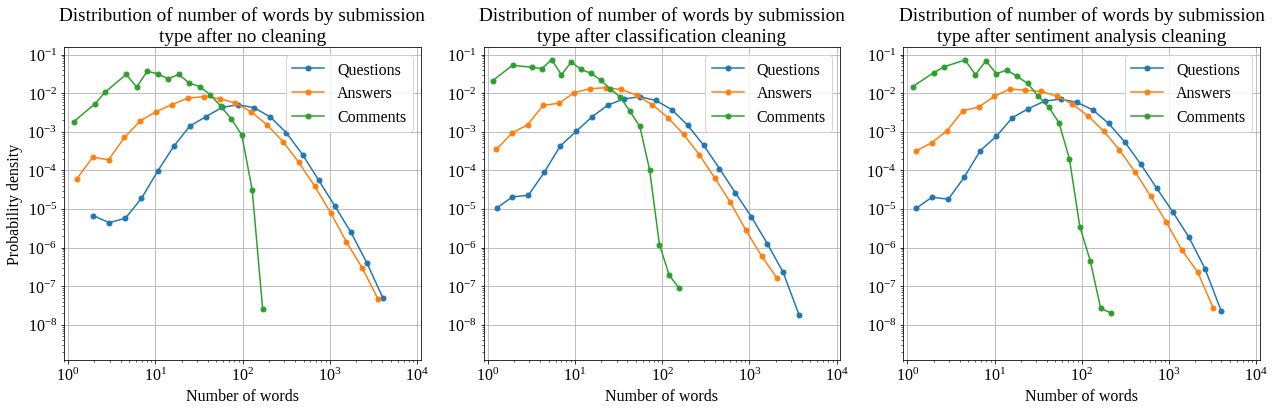

In [6]:
def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):
    """ Bins data accourding to spacing function and number of given bins """
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, (lab, dat) in enumerate(zip(("No cleaning", "Classification cleaning", "Sentiment analysis cleaning"), (so.body, so.cclean, so.sclean))):
    ax_ = axs[i]
    # Plot distribution of words
    qx, qdist = bins(np.array([len(text.split()) for text in dat[so.type=="q"]]))
    ax, adist = bins(np.array([len(text.split()) for text in dat[so.type=="a"]]))
    cx, cdist = bins(np.array([len(text.split()) for text in dat[so.type=="c"]]))
    with open(os.path.join("data", lab.replace(" ", "") + ".json"), "w") as f:
        json.dump({
            "qx": qx.tolist(),
            "qdist": qdist.tolist(),
            "ax": ax.tolist(),
            "adist": adist.tolist(),
            "cx": cx.tolist(),
            "cdist": cdist.tolist(),
        }, f)

    ax_.plot(qx, qdist, marker=".", ms=10, label="Questions")
    ax_.plot(ax, adist, marker=".", ms=10, label="Answers")
    ax_.plot(cx, cdist, marker=".", ms=10, label="Comments")
    ax_.grid()
    ax_.set_xscale("log")
    ax_.set_yscale("log")
    ax_.set_title("Distribution of number of words by submission\ntype after %s" % lab.lower())
    ax_.set_xlim([0.9, 1.1*10**4])
    ax_.set_ylim([10**-8.9, 10**-0.8])
    ax_.set_xlabel("Number of words")
    if i == 0:
        ax_.set_ylabel("Probability density")
    ax_.legend(loc=1)
plt.tight_layout()


<strong>TODO: Comment on figures and probably more figures</strong>

# 3. Analysis

### 3.1. Stack Overflow as a Graph

The content on Stack Overflow can naturally be understood as a network in which the individual users are linked by the interactions they make.  
The data can be modelled as a directed, weighted graph, in which each node is a unique user on Stack Overflow, and each edge is an interaction between a pair of users, this being a user answering a question asked by another user or commenting on either a question or an answer by another user.
The associated weight is the number of times these users have interacted in the given direction.  

`NetworkX`, a `Python` package for working with graphs, is used for creating the Stack Overflow network graph as it gives the ability to create a wide range of graph types, and in our case importantly to create big, complex graphs while not sacrificing computation speed.

Some notes about the Stack Overflow network graph creation:

1. During the creation of the graph, a some potential edges are removed for two reasons:
    - There are many questions which naturally do not have any parent-author, and would create a self-loop (which we are not interested in keeping trakc of).
    - A lot of especially comments, but also answers, are interacting with a `question_id` or `answer_id` which is not contained in the data, and can therefore not be mapped to a parent-author. This is natural, as the solution to this issue would be to be in possesion of *all* data, which is not feasible.

2. The network is ideally graphed as a directed, weighted graph, as all interactions happen one-way (until a recipent of an answer or comment comments back).
The function though also contains the ability to create an simpler unweighted, undirected graph, which will be utilized when computing modularity and using the Louvain algorithm.

3. For each user, the programming language(s) they have made a submission on is saved as node attribute with an associated weight counting the number of times this has happened. 
Some users have made submissions on more than one programming language, and these are the users who bind together the different programming languages in the Stack Overflow network graph. 
The programming language with the highest weight is deemed a user's top language, and is what we use for partitioning the big graph into programming language specific communities.

In [7]:
### This cell contains the function for creating the big Stack Overflow network graph
def so_network(so_data, directed=True):

    ## Get Questions, answers and comments seperately
    questions = so_data.loc[so_data['type'] == 'q']
    answers = so_data.loc[so_data['type'] == 'a']
    comments = so_data.loc[so_data['type'] == 'c']

    ## Get authors of questions and answers
    question_authors = dict(zip(questions['question_id'], questions['owner/user_id']))
    answer_authors = dict(zip(answers['answer_id'], answers['owner/user_id']))

    ## Find parent id's of all datapoints
    so_data['parent_author'] = ""
    for index, row in tqdm(so_data.iterrows(), total=len(so_data)):

        ## If question, no parent author (no self-loops)
        if row['type'] == 'q':  
            so_data.at[index, 'parent_author'] = None

        ## If answer, parent author is author of question answered
        elif row['type'] == 'a':
            try:
                so_data.at[index, 'parent_author'] = question_authors[str(row['question_id'])]
            except: # Parent missing
                so_data.at[index, 'parent_author'] = None
        
        ## If comment, parent author is either author of commented question or answer
        else:
            try:  # Commenting on an answer
                so_data.at[index, 'parent_author'] = answer_authors[str(row['answer_id'])]
            except:
                try:  # Commenting on a question
                    so_data.at[index, 'parent_author'] = question_authors[str(row['question_id'])]
                except:  # Parent missing
                    so_data.at[index, 'parent_author'] = None

    ## Filter for NANs, there are a lot for comments..
    print('Data shape before filtering for NANs', so_data.shape)
    so_data = so_data[so_data['parent_author'].notnull()]
    so_data = so_data[so_data['owner/user_id'].notnull()]
    so_data = so_data[so_data['parent_author'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != so_data['parent_author']]
    print('Data shape after filtering for NANs', so_data.shape)

    ## Create weighted edge list for all sets of source, target and programming language
    edge_list = so_data.groupby(['owner/user_id', 'parent_author', 'language']).size().to_frame('weight').reset_index()

    ## Make language and weight info-dict
    edge_list['language_weight'] = edge_list.apply(lambda row: {row['language']:row['weight']}, axis=1)

    print('Edge list shape accomodating for bilingual source-target pairs', edge_list.shape)

    ## Find duplicates, ie. source-target pairs interacting on 2 or more different prog. languages
    bilinguals = edge_list[edge_list.duplicated(['owner/user_id', 'parent_author'], keep=False)]
    bilinguals_last = bilinguals[bilinguals.duplicated(['owner/user_id', 'parent_author'], keep='first')]

    ## Drop duplicates keeping first instance
    edge_list = edge_list.drop_duplicates(['owner/user_id', 'parent_author'], keep='first')

    ## Add the duplicates' language-weight data to the first instance of the interaction
    for _, row in tqdm(bilinguals_last.iterrows(), total=len(bilinguals_last)):
        index = edge_list.index[(edge_list['owner/user_id'] == row['owner/user_id']) & (edge_list['parent_author'] == row['parent_author'])]
        edge_list.loc[index]['language_weight'].item()[row['language']] = row['weight']

    print('\nEdge list after accomodating for bilingual interaction pairs', edge_list.shape)

    ## Define nodes and weights
    sources = list(edge_list['owner/user_id'])
    targets = list(edge_list['parent_author'])
    weights = list(edge_list['weight'])
    language_weights = list(edge_list['language_weight'])
    
    ## Create graph, adding nodes and edges
    if directed:
        so_graph = nx.DiGraph()
    else:
        so_graph = nx.Graph()
        
    for i in tqdm(range(len(sources))):
        ## If node not already in graph, we add it, otherwise we add the language weights
        if sources[i] not in so_graph:
            so_graph.add_node(sources[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[sources[i]]['languages']:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])
        
        if targets[i] not in so_graph:
            so_graph.add_node(targets[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[targets[i]]['languages']:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])

        so_graph.add_edge(sources[i], targets[i])#, weight=sum(language_weights[i].values()))

    ## Add  top language as node attribute
    for i in so_graph:
        top_lang = sorted(so_graph.nodes[i]['languages'], key=so_graph.nodes[i]['languages'].get)[-1]
        so_graph.nodes[i]['top_language'] = top_lang
        so_graph.nodes[i]['color'] = language_colors[so_graph.nodes[i]['top_language']]

    return so_graph


### This code creates the Stack Overflow graph, both directed and undirected, and saves as pickle
so_graph = so_network(so_data=so, directed=True)
path = 'so_graph.pkl'
nx.write_gpickle(so_graph, path)

so_undirected_graph = so_network(so_data=so, directed=False)
path = 'so_undirected_graph.pkl'
nx.write_gpickle(so_undirected_graph, path)

100%|██████████| 1272553/1272553 [02:00<00:00, 10601.13it/s]


Data shape before filtering for NANs (1272553, 11)
Data shape after filtering for NANs (780540, 11)
Edge list shape accomodating for bilingual source-target pairs (563973, 5)


100%|██████████| 6379/6379 [14:10<00:00,  7.50it/s]



Edge list after accomodating for bilingual interaction pairs (557594, 5)


100%|██████████| 1272553/1272553 [01:53<00:00, 11166.31it/s]


Data shape before filtering for NANs (1272553, 11)
Data shape after filtering for NANs (780540, 11)
Edge list shape accomodating for bilingual source-target pairs (563973, 5)


  0%|          | 2110/557594 [00:00<00:32, 17069.55it/s]


Edge list after accomodating for bilingual interaction pairs (557594, 5)


100%|██████████| 557594/557594 [00:06<00:00, 88758.56it/s] 


Now we can perform basic network analysis on the Stack Overflow network graph, and further on the individual programming language specific partitions, which we create as subgraphs, as to get a better understanding of the size of these graphs and how they differentiate.

In [8]:
### This cell loads the pickled data, finds partitions based on programming language, then computes and displays graphs basic summary

## Load pickled Stack Overflow graph
so_graph_path = 'so_graph.pkl'
if "so_graph" not in locals():
    so_graph = nx.read_gpickle(so_graph_path)

## Retrieve the 16 different programming languages as partitions
so_partitions = {prog_lang : [i for i in so_graph if so_graph.nodes[i]["top_language"] == prog_lang] for prog_lang in tqdm(loved_languages)}

## Now these are all gathered in a dict
graphs = {prog_lang : None for prog_lang in loved_languages.keys()}
for prog_lang in tqdm(graphs.keys()):
    graphs[prog_lang] = so_graph.subgraph(so_partitions[prog_lang])
graphs['stack_overflow'] = so_graph


## Function for computing number of nodes, number of links and density of graph
def basic_graph_analysis(graph):
    num_nodes = graph.number_of_nodes()
    num_links = graph.number_of_edges()
    density = nx.classes.function.density(graph)
    return num_nodes, num_links, round(density, 7)

## Function for computing in- and out-degrees
def graph_degrees(graph):
    in_degrees = list(dict(graph.in_degree()).values())
    out_degrees = list(dict(graph.out_degree()).values())
    return in_degrees, out_degrees

## Table displaying basic metrics
t = Table()
t.add_row(["Language", "Num Nodes", "Num Links", "Density"])
for prog_lang in graphs.keys():
    num_nodes, num_links, density = basic_graph_analysis(graph=graphs[str(prog_lang)])
    t.add_row([prog_lang.capitalize() if not prog_lang.startswith("stack") else "Full graph", num_nodes, num_links, density], [1, 0, 0, 0])

print("Basic statistics Stack Overflow network graph and programming language specific subgraphs")
print(t)

100%|██████████| 16/16 [00:00<00:00, 151.78it/s]


Basic statistics Stack Overflow network graph and programming language specific subgraphs
Language    | Num Nodes | Num Links | Density  
Rust        |      4411 |     12846 | 0.0006604
Typescript  |     17828 |     26163 |  8.23e-05
Python      |     19845 |     29519 |   7.5e-05
Kotlin      |     11161 |     20097 | 0.0001613
Go          |     12774 |     29255 | 0.0001793
Dart        |      7758 |     14967 | 0.0002487
C#          |     19186 |     31971 |  8.69e-05
Javascript  |     20639 |     27686 |   6.5e-05
Haskell     |      6402 |     29341 |  0.000716
Java        |     20700 |     29146 |   6.8e-05
C++         |     15534 |     35969 | 0.0001491
Ruby        |     14175 |     32652 | 0.0001625
C           |     16039 |     43060 | 0.0001674
Perl        |      8277 |     27562 | 0.0004024
Objective-c |     14518 |     28792 | 0.0001366
Vba         |     13528 |     33650 | 0.0001839
Full graph  |    222775 |    557594 |  1.12e-05


As is clear on the above table, the number of nodes and edges varies quite a bit for the different programming languages. 
The data collection process did not explicitly bias on the basis of programming popularity or belovedness but did in fact collect different amounts of data for each programming language, and this is what mainly causes the size difference.

We see that the graph densities are very low, which is no suprise given the very large number of nodes. Recall density is given by:
\begin{equation*}
    density(G) = \frac{m}{n \cdot (n-1)}
\end{equation*}
In which n is the number of nodes and m is number of edges, ie. we would need m = $n \cdot (n-1)$ edges for a complete graph with density 1.

Below, we compute the in- and out-degrees of the big graph and subgraphs.

In [9]:
### This cell computes and displays degree summary
t = Table()
t.add_header(["Language", "Num Nodes", "Num Links", "Density", "Avg in.", "Avg out.", "Median in.", "Median out.", "Max in.", "Max out.", "Min in.", "Min out.", "Mode in.(#)", "Mode out.(#)"])

for prog_lang in graphs.keys():

    num_nodes, num_links, density = basic_graph_analysis(graph=graphs[str(prog_lang)])

    ## Get degrees
    in_degrees, out_degrees = graph_degrees(graph=graphs[str(prog_lang)])

    ## Calculate in-statistics
    avg_in = round(np.mean(in_degrees), 2)
    median_in = np.median(in_degrees)
    max_in = max(in_degrees)
    min_in = min(in_degrees)
    mode_in = scipy.stats.mode(in_degrees)

    ## Calculate out-statistics
    avg_out = round(np.mean(out_degrees), 2)
    median_out = np.median(out_degrees)
    max_out = max(out_degrees)
    min_out = min(out_degrees)
    mode_out = scipy.stats.mode(out_degrees)

    ## Add to table
    t.add_row([prog_lang.capitalize(), num_nodes, num_links, density, avg_in, avg_out, median_in, median_out, max_in, max_out, min_in, min_out, f'{int(mode_in[0])} ({int(mode_in[1])})', f'{int(mode_out[0])} ({int(mode_out[1])})'], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

print("Basic Graph Analysis: Number of nodes, edges and density &  Degree (in. and out.) analysis for programming language partitions and big SO graph\n")
print(t)

Basic Graph Analysis: Number of nodes, edges and density &  Degree (in. and out.) analysis for programming language partitions and big SO graph

Language       | Num Nodes | Num Links | Density   | Avg in. | Avg out. | Median in. | Median out. | Max in. | Max out. | Min in. | Min out. | Mode in.(#) | Mode out.(#)
---------------+-----------+-----------+-----------+---------+----------+------------+-------------+---------+----------+---------+----------+-------------+-------------
Rust           |      4411 |     12846 | 0.0006604 |    2.91 |     2.91 |        2.0 |         1.0 |     640 |     1733 |       0 |        0 |    1 (1124) |     1 (1889)
Typescript     |     17828 |     26163 |  8.23e-05 |    1.47 |     1.47 |        1.0 |         1.0 |     395 |      568 |       0 |        0 |    0 (7662) |    1 (10109)
Python         |     19845 |     29519 |   7.5e-05 |    1.49 |     1.49 |        1.0 |         1.0 |      79 |      318 |       0 |        0 |    0 (7029) |     1 (9979)
Kotli

The degree table and histograms above showcase som key insights in the data:
 - The max in and out-degrees are significantly larger for several of the programming languages which featured a smaller number of nodes and edges, which indicates that there are less widespread knowledge of the programming language and fewer, bigger players who help the community. This is especially true at Rust, which has one user whose outgoing edges accounted for around 15% of the total number of edges. 
 - The mode out suggests, that for all programming language partitions, as well as the big graph, around half of users come to Stack Overflow, leave one answer or comment and then leaves. 
 
Below is the in- and out-degrees plotted as histograms for the single programming language partitioned subgraphs.

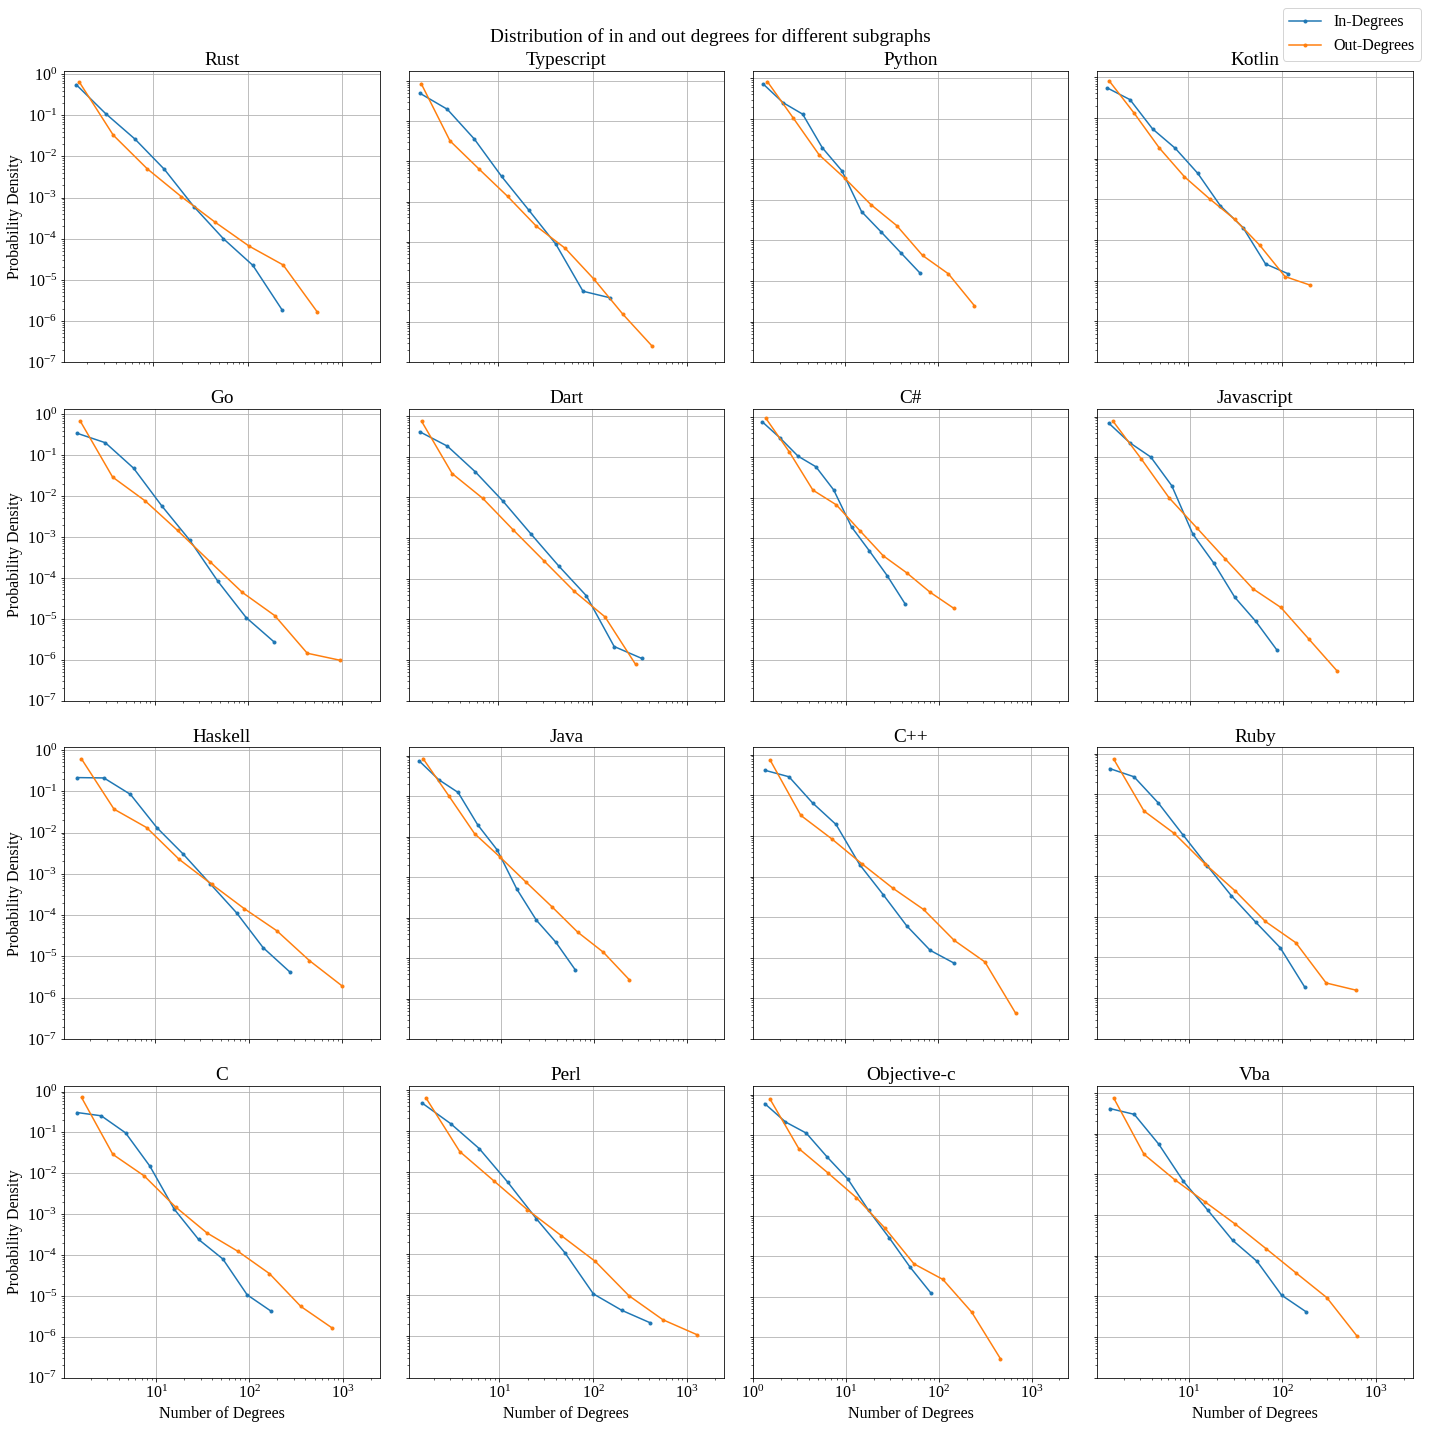

In [10]:
### This cell plots the in-out histograms for the single programming language partitioned subgraphs

## Function for computing histograms
def in_out_degree_histogram(graph):

    in_degrees, out_degrees = graph_degrees(graph)
    bins = np.logspace(0, np.log10(max(in_degrees)), 10)
    in_hist, edges = np.histogram(in_degrees, bins=bins, density=True)
    x_in = (edges[1:] + edges[:-1]) / 2.
    x_in, in_hist = x_in[in_hist>0], in_hist[in_hist>0]

    bins = np.logspace(0, np.log10(max(out_degrees)), 10)
    out_hist, edges = np.histogram(out_degrees, bins=bins, density=True)
    x_out = (edges[1:] + edges[:-1]) / 2.
    x_out, out_hist = x_out[out_hist>0], out_hist[out_hist>0]
    
    return in_hist, x_in, out_hist, x_out

## Create folder for holding json data for plotting on the webpage
os.makedirs("degreeplots", exist_ok=True)

## Create plots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Distribution of in and out degrees for different subgraphs')

for i in range(4):
    for j in range(4):
        prog_lang = list(graphs.keys())[i*4+j]

        ## Compute histogram
        in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs[str(prog_lang)])
        
        ## We save histogram plot data as json for plotting on the webpage
        path = 'degreeplots/' + str(prog_lang) + '_degreehist.json'
        with open(path, "w") as f:
            json.dump({
                "in_hist": in_hist.tolist(),
                "x_in": x_in.tolist(),
                "out_hist": out_hist.tolist(),
                "x_out": x_out.tolist(),
            }, f)
        
        axs[i,j].plot(x_in, in_hist, marker='.', label='In-Degrees')
        axs[i,j].plot(x_out, out_hist, marker='.', label='Out-Degrees')
        axs[i,j].set_xscale('log')
        axs[i,j].set_yscale('log')
        axs[i,j].set_xlim([np.log10(1), 2.5e3])
        axs[i,j].set_ylim([1e-7, np.log10(1)])
        axs[i,j].set_title(f"{prog_lang.capitalize()}")
        axs[i,j].grid()

## Get labels on legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:2], labels[0:2])

for ax in axs.flat:
    ax.set(xlabel='Number of Degrees', ylabel='Probability Density')
    ax.label_outer()
plt.tight_layout()
plt.show()

From the degree plots, we see that the different networks are very similar, though still importantly resemble real, non-random networks.

The entire Stack Overflow network degree distribution can be seen below.

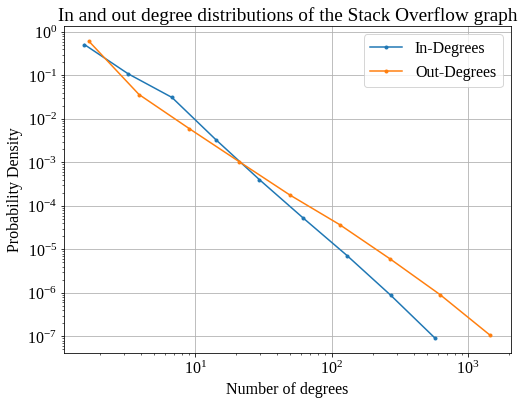

In [11]:
### This cell plots the in-out histogream for the big Stack Overflow network

## Create plot
fig, ax = plt.subplots(figsize=(8, 6))

## Compute histogram
in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs['stack_overflow'])

## We save histogram plot data as json for plotting on the webpage
path = 'degreeplots/' + 'so_graph' + '_degreehist.json'
with open(path, "w") as f:
    json.dump({
        "in_hist": in_hist.tolist(),
        "x_in": x_in.tolist(),
        "out_hist": out_hist.tolist(),
        "x_out": x_out.tolist(),
    }, f)

ax.plot(x_in, in_hist, marker='.', label='In-Degrees')
ax.plot(x_out, out_hist, marker='.', label='Out-Degrees')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Stack Overflow')
ax.set_xlabel('Number of degrees')
ax.set_ylabel('Probability Density')
ax.set_title(f"In and out degree distributions of the Stack Overflow graph")
ax.grid()
ax.legend(loc='upper right')

plt.show()


From here, we switch to the undirected graph version of the Stack Overflow network graph, as using a directed graph when computing modularity and using the Louvain algorithm poses trouble.

First we look to compute the modularity of the Stack Overflow network graph, as this is a key indicator of whether the partitions, being the different programming languages, shape the graph such that it is distinct from a random graph.



In [12]:
### This cell is used for computing the modularity of the Stack Overflow Network

## Load the undirected Stack Oveflow network graph if not in memory already
so_undirected_graph_path = 'so_undirected_graph.pkl'
if "so_undirected_graph" not in locals():
    so_undirected_graph = nx.read_gpickle(so_undirected_graph_path)

## Retrieve the 16 different programming languages as partitions
so_undirected_partitions = {prog_lang : [i for i in so_undirected_graph if so_undirected_graph.nodes[i]["top_language"] == prog_lang] for prog_lang in loved_languages}

## Compute modularity using Networkx modularity function
so_undirected_modularity = nx.algorithms.community.modularity(G=so_undirected_graph, communities=so_undirected_partitions.values())
print("Modularity of Stack Overflow programming language splits: %.4f" % so_undirected_modularity)

Modularity of Stack Overflow programming language splits: 0.7357


The modularity found is clearly distinct from zero, but in order to be certain we will utilize a configuration model for generating random counterparts to the Stack Overflow Network graph.  
This is done by making a copy of the graph, and then shuffling all target nodes.
We can then compare the modularity of these to the found modularity.




In [13]:
### This cell computes the modularity of 200 randomised versions of the undirected Stack Overflow network graph

## Function for creating randomized versions of the Stack Overflow network graph
def conf_model(graph):
    
    ## Create graph that is a copy of nodes
    g = nx.Graph()
    g.add_nodes_from(graph.nodes)
    
    ## Shuffle edge targets and add edges
    sources, targets = np.transpose(graph.edges)
    np.random.shuffle(targets)

    ## Add shuffled edges to new graph
    edges = [(source, target) for source, target in np.transpose([sources, targets])]
    g.add_edges_from(edges)

    return g

random_modularities = [nx.algorithms.community.modularity(G=conf_model(so_undirected_graph), communities=so_undirected_partitions.values()) for _ in tqdm(range(200))]
print("")
print("Average modularity of shuffled (random) Stack Ovefflow graphs: %.10f" % np.mean(random_modularities))
print("Standard deviation: %.10f" % np.std(random_modularities, ddof=1))

100%|██████████| 200/200 [20:24<00:00,  6.12s/it]


Average modularity of shuffled (random) Stack Ovefflow graphs: -0.0000583462
Standard deviation: 0.0003243362


As we can see, these modularities are all very close to zero with a tiny standard deviation, meaning they are completely random.  
In the context of how the randomized versions of the Stack Overflow network graph are made, this makes sense, as we know there are 16 different communities, which when shuffled will create much more random versions than had there been only say 3 communities.  

The distribution of these modularities are shown below, and seem normally distributed very closely around zero.

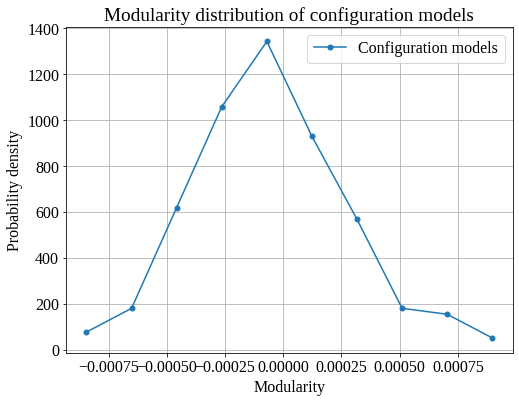

In [14]:
## Use binning function from Part 1
mod, dens = bins(random_modularities, lambda x, b: np.linspace(min(x), max(x), b), bins=10)

## Save as json for plotting on webpage
path = 'degreeplots/' + 'conf_model_modularity_hist.json'
with open(path, "w") as f:
    json.dump({
        "mod": mod.tolist(),
        "dens": dens.tolist(),
    }, f)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mod, dens, marker=".", ms=10, label="Configuration models")
ax.grid()
ax.set_title("Modularity distribution of configuration models")
ax.set_xlabel("Modularity")
ax.set_ylabel("Probability density")
ax.legend()

As the last step in this network analysis, we use the Louvain algorithm to split the Stack Overflow network into communities.  
The Louvain algorithm is called using the communities API which does community detection for Networkx graphs.  
This is not supported for directed graphs using Networkx, and we will therefore also here use the undirected version of the Stack Overflow network graph.

In [15]:
### This cell is used for computing the modularity of the Louvain split Stack Overflow network graph

partition = cm.best_partition(so_undirected_graph)
nc = max(partition.values()) + 1
ns = [[] for i in range(nc)]
for i, p in partition.items():
    ns[p].append(i)
print("Modularity according to Louvain algorithm: %.4f" % nx.algorithms.community.modularity(G=so_undirected_graph, communities=ns))
print("Number of partitions: %i" % nc)

Modularity according to Louvain algorithm: 0.7629
Number of partitions: 6128


Running the Louvain algorithm to end this partitioning investigation, yields a higher modularity with way more partitions partitions.  
The Louvain algorithm thus found a higher modularity than with the programming language specific partitioning, and this shows that it is possible to divide the graph into components that are even stronger internally connected according to the modularity measure.

Finally, the Stack Overflow network graph is vizualized using Netwulf.
This runs very slow, and due to the size of the graph, we had issues getting it to display in the notebook. Therefore, the network is not shown here, but we downloaded it directly, and it is shown on the website.

In [ ]:
### Vizualizing the Stack Overflow network graph

## We will reduce the graph a bit by getting rid of smaller weakly connected components which will float around the main network structue using Netwulff
so_graph_path = 'so_graph.pkl'
reduced_so_graph = nx.read_gpickle(so_graph_path)

print('Before reduction')
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())
#
for component in list(nx.weakly_connected_components(reduced_so_graph)):
    if len(component) < 100:
        for node in component:
            reduced_so_graph.remove_node(node)

print('After reduction')
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())

## Netwulf configuration
nf_config = {
    # Input/output
    'zoom': 0.6,
    # Physics
    'node_charge': -8,
    'node_gravity': 0.1,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    # Nodes
    'node_fill_color': '#79aaa0',
    'node_stroke_color': '#555555',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': True,
    'node_size': 50,
    'node_stroke_width': 1,
    'node_size_variation': 0.24,
    # Links
    'link_color': '#ffffff',
    'link_width': 2,
    'link_alpha': 0.5,
    'link_width_variation': 0.5,
    # Thresholding
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1}

## Initiate vizualization, this takes at least 10 minutes to fully render
nf.visualize(reduced_so_graph, config=nf_config)

### 3.2. Sentiment Analysis and Loved Languages

Sentiment scores are calculated by VADER as a compound score of positive, negative, and neutral sentiments.

VADER uses both context and dictionary based methods to calculate sentiments, which should yield more accurate results than simply using dictionary based methods.

First sentiments are calculated for each submission, and their distribution is plotted.

In [16]:
analyzer = vader.SentimentIntensityAnalyzer()
so["compound"] = [analyzer.polarity_scores(body)["compound"] for body in tqdm(so.sclean)]

100%|██████████| 1272553/1272553 [09:18<00:00, 2278.87it/s]


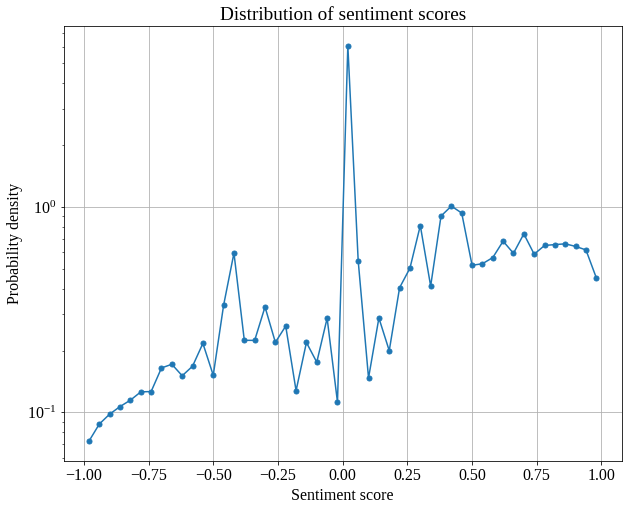

In [17]:
sent, prob = bins(so.compound, lambda x, b: np.linspace(-1, 1, b), bins=50)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(sent, prob, marker=".", ms=10)
ax.set_title("Distribution of sentiment scores")
ax.set_xlabel("Sentiment score")
ax.set_ylabel("Probability density")
ax.set_yscale("log")
ax.grid()
with open(os.path.join("data", "sentdist.json"), "w") as f:
    json.dump({
        "sent": sent.tolist(),
        "prob": prob.tolist(),
    }, f)

In [18]:
print("Negative (<0): %.2f %%" % (100 * len(so.loc[so.compound<0]) / len(so)))
print("Neutral  (=0): %.2f %%" % (100 * len(so.loc[so.compound==0]) / len(so)))
print("Positive (>0): %.2f %%" % (100 * len(so.loc[so.compound>0]) / len(so)))

Negative (<0): 19.45 %
Neutral  (=0): 23.75 %
Positive (>0): 56.80 %


While mostly positive, around a quarter of submissions are completely neutral according to VADER. This is not unexpected for two reasons: Most submissions are rather short, and objective language is commonplace.

With the sentiments calculated, their correlation with the belovedness of different languages according to the developer survey can be calculated.
For this, the sentiment of a language is calculated as the unweighted mean of submissions' sentiments.

In [19]:
grouped = so.groupby("language")
mean_sents = grouped.compound.mean()

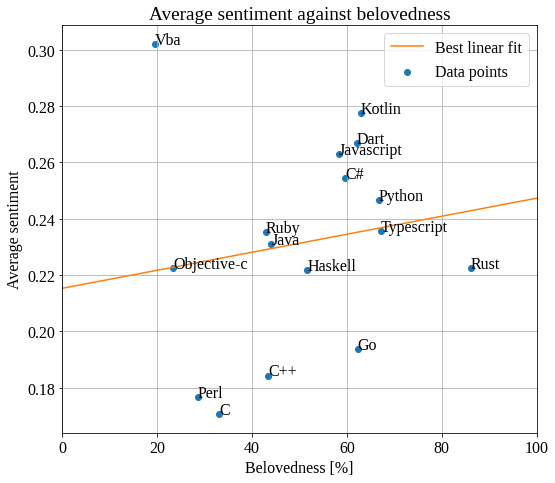

In [20]:
x = np.array(list(loved_languages.values()))
m = np.array([mean_sents[lang] for lang in loved_languages])

plt.figure(figsize=(8, 7))
# Plot means
plt.scatter(x, m, label="Data points")
lm_m = np.polyfit(x, m, 1)
lm_fn = np.poly1d(lm_m)
ends = np.array([0, 100])
plt.plot(ends, lm_fn(ends), c=tab_colours[1], label="Best linear fit")
for i, lang in enumerate(loved_languages):
    plt.annotate(lang.capitalize(), (x[i], m[i]))
plt.title("Average sentiment against belovedness")
plt.xlabel("Belovedness [%]")
plt.ylabel("Average sentiment")
plt.xlim(ends)
plt.grid()
plt.legend()
plt.tight_layout()

with open(os.path.join("data", "sentcorr.json"), "w") as f:
    json.dump({"belovedness": x.tolist(), "mean_sent": m.tolist(), "a": float(lm_m[0]), "b": float(lm_m[1])}, f)

In [21]:
print("Correlation: %.4f" % scipy.stats.pearsonr(x, m)[0])

Correlation: 0.1571


A weak, positive correlation between the belovedness of the languages and the average sentiment.
However, VBA is a clear outlier as both the least beloved language but also the one with the highest average sentiment.
Without this outlier, the correlation would be much stronger.

It should be noted that the belovedness of the languages were taken from 2020 Stack Overflow Developer Survey, which was conducted in <a href="https://insights.stackoverflow.com/survey/2020">February 2020</a>, while the sentiment analysis.
To make sure no temporal biases exist, the average sentiments are plotted over time.

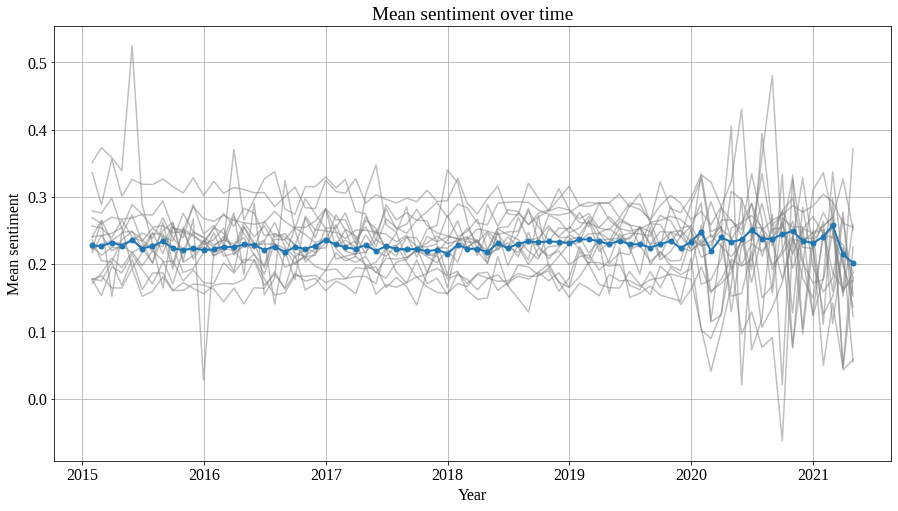

In [22]:
plt.figure(figsize=(15, 8))
for lang in loved_languages:
    sub = so.loc[so.language==lang].set_index("created")
    plt.plot(sub.resample("1M")["compound"].mean(), lw=1.5, alpha=0.5, color="gray")
plt.plot(so.set_index("created").resample("1M")["compound"].mean(), marker=".", ms=10, lw=2)
plt.xlabel("Year")
plt.ylabel("Mean sentiment")
plt.title("Mean sentiment over time")
plt.grid()
plt.show()

While the sentiment within languages varies within languages, the overall sentiment is largely unchanged over the entire period.
The increased variance in the right hand side of the plot is explained by the fact that the amount of data decreases significantly after 2019.

### 3.3. Building a Language Classifier

TF-IDF is a method for ranking the importance of words in a document. While it is not a common usecase, it is simple to extend this importance ranking into a language classifier.

We work with 16 different programming languages, so we consider 16 documents, each containing the bodies of all questions, answers, and comments from SO threads tagged with the language. First, the data is organized by question ID.
In order to test our classifier, we split each document into a training and a validation document, with the training one containing the text of submissions from 90 % of the threads.

The training set is a large document containing the text from all submissions with the given language.
The validation set is instead split by threads, such that validation is performed based on all submissions in a given thread.

In [23]:
# Build lookup table to get all submissions with given question ID
subs_by_id = defaultdict(list)
for _, row in tqdm(so.iterrows(), total=len(so)):
    subs_by_id[row.question_id].append(row)
subs_by_id = { question_id: pd.DataFrame(rows) for question_id, rows in tqdm(subs_by_id.items()) }

100%|██████████| 180890/180890 [03:12<00:00, 941.32it/s] 


In [24]:
train_format = os.path.join("data", "local_train_%s.txt")
val_format = os.path.join("data", "local_val_%s.txt")

# Combine texts by programming language and split into train and validation
train_validation_split = 0.9
n_train_qs = int(train_validation_split * len(subs_by_id))
q_ids = list(subs_by_id)
q_ids_train = set(q_ids[:n_train_qs])

keys = list(subs_by_id)
for lang in loved_languages:
    try:
        os.remove(train_format % lang)
        os.remove(val_format % lang)
    except FileNotFoundError:
        pass
for i, qid in tqdm(enumerate(keys), total=len(subs_by_id)):
    subs = subs_by_id[qid]
    lang = subs.iloc[0].language
    if lang not in loved_languages:
        continue
    if qid in q_ids_train:
        with open(train_format % lang, "a") as ftrain:
            ftrain.write(" ".join(itertools.chain(*(b.split() for b in subs.cclean))) + " ")
    else:
        with open(val_format % lang, "a") as fval:
            fval.write(" ".join(itertools.chain(*(b.split() for b in subs.cclean))) + "\n")
    del subs_by_id[qid]  # No longer needed, so clear from memory
del subs_by_id

train_texts = dict()
val_texts = dict()
for lang in tqdm(loved_languages):
    with open(train_format % lang) as f:
        train_texts[lang] = f.read().split()
    with open(val_format % lang) as f:
        val_texts[lang] = [words.split() for words in f.read().split("\n")]

100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Text(0, 0.5, 'Number of words')

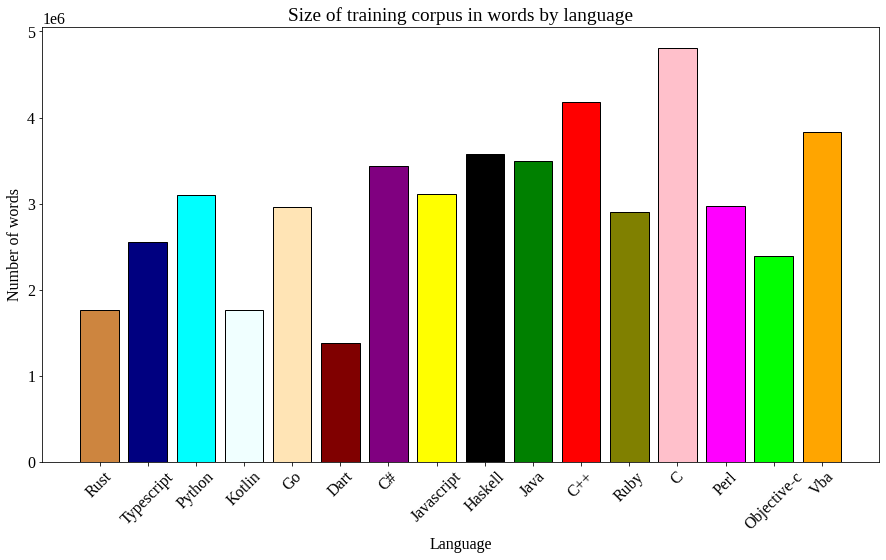

In [25]:
# Corpus size distribution
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.bar(
    range(len(loved_languages)),
    [len(corpus) for corpus in train_texts.values()],
    tick_label=[x.capitalize() for x in train_texts],
    color=language_colors.values(),
    edgecolor="black",
)
ax.tick_params(axis="x", rotation=45)
ax.set_title("Size of training corpus in words by language")
ax.set_xlabel("Language")
ax.set_ylabel("Number of words")

With the data split into training and validation, the classifier can be constructed.
The training consists of building a vocabulary $v$ that maps words to TF-IDF scores for each training document.
Then, given a cleaned text, the classifier calculates a score $S_l$ for each language $l$ using the formula
\begin{equation*}
    S_l=\sum_{\text{word}\,\in\,\text{text}} \begin{cases}
        v_l(\text{word}) &\text{if word}\in v_l\\
        0 &\text{otherwise}
    \end{cases}
\end{equation*}
The language $l^*$ that maximizes $S_l$ is then predicted:
\begin{equation*}
    l^* = \mathop{\operatorname{argmax}}\limits_{l\,\in\,\text{languages}} S_l
\end{equation*}
All $v_l$ are constructed as a dictionary of dictionaries - `tfidf` in the code. This dictionary maps languages to their corresponding $v_l$, which again is a dictionary that maps words to TF-IDF values.

In [26]:
# Build classifier using TF-IDF
tfidf = dict()  # { language: { word: TF-IDF score } }
counts = { lang: Counter(train_texts[lang]) for lang in loved_languages }
t = Table()
t.add_header(["Language", "Size of vocabulary"])
for lang in loved_languages:
    # Count of each for given language
    c = counts[lang]
    # Calculate TF and IDF
    tf = { word: count / len(train_texts[lang]) for word, count in c.items() }
    idf = {
        word: np.log(
            len(c) /\
            (1 + sum(word in vocab for vocab in counts.values()))
        )
        for word in c
    }
    tfidf[lang] = { word: tf[word] * idf[word] for word in c }
    t.add_row([lang.capitalize(), thousand_seps(len(tfidf[lang]))], [1, 0])
print(t)

Language    | Size of vocabulary
------------+-------------------
Rust        |            120,694
Typescript  |            203,067
Python      |            295,553
Kotlin      |            172,554
Go          |            213,277
Dart        |            109,450
C#          |            290,992
Javascript  |            276,666
Haskell     |            127,662
Java        |            325,252
C++         |            285,826
Ruby        |            229,856
C           |            280,762
Perl        |            198,828
Objective-c |            203,682
Vba         |            230,313


With the vocabularies constructed, the classifier is ready to be evaluated.
These vocabularies are quite large, so in the interest of limiting memory usage, only a subset of them can be used.
This is done by reducing each $v_l$ to only those words that have the $k$ highest scores.
The classifier is validated on the validation set using all $k\in\{1, 10, 10^2, 10^3, 10^4, 10^5\}$.
We use both raw accuracy and weighted F1 for measuring classification accuracies.

In [27]:
def classify(text: str, cleaned=True, tfidf_: dict=None) -> tuple[str, dict]:
    """
    Classify text by TF-IDF scores by summing TF-IDF for every word in every language and selecting language with highest score
    Returns language and probability distribution over all languages
    An optional TF-IDF dict can be given. Default is the tfidf variable
    """
    tfidf_ = tfidf_ or tfidf
    # Make sure text is cleaned
    if not cleaned:
        text = clean(text)
    word_counts = Counter(text.split())
    scores = dict()
    langs = list(tfidf_.keys())
    for lang, word_tfidf in tfidf_.items():
        scores[lang] = 0
        for word, count in word_counts.items():
            scores[lang] += word_tfidf.get(word, 0)
        if scores[lang] == 0:
            scores[lang] = -float("inf")
    # Calculate probability distribution using softmax
    prob = scipy.special.softmax(np.array(list(scores.values())))
    if np.any(np.isnan(prob)):  # In case of no known words, select random to prevent bias
        return random.choice(list(loved_languages)), 1 / len(loved_languages)
    return langs[prob.argmax()], prob

def top(counts: dict, n: int) -> dict:
    """ Takes a dict { key: count } and returns a dict with the n key-count pairs with highest counts """
    n_highest = sorted(counts.values())[-n] if n <= len(counts) else min(counts.values())
    return { key: count for key, count in counts.items() if count >= n_highest }

def get_conf_mat(tfidf_: dict=None):
    """ Get confusion matrix over threads using a given tfidf dict """
    conf_mat = np.zeros((len(loved_languages), len(loved_languages)), dtype=int)
    lang_indices = { lang: i for i, lang in enumerate(loved_languages) }
    for lang, i in lang_indices.items():
        texts = val_texts[lang]
        for words in texts:
            pred, _ = classify(" ".join(words), tfidf_=tfidf_)
            conf_mat[lang_indices[pred], i] += 1
    return conf_mat

def f1(conf_mat: np.ndarray) -> float:
    """ Calculate weighted f1 score for a given confusion matrix """
    per_class = conf_mat.sum(axis=0)  # Number of submissions by class
    # Generate fake true and pred vectors that satisfy conf mat to calculate f1 score
    y_true = np.array(list(itertools.chain(*([i]*per_class[i] for i in range(len(conf_mat))))))
    y_pred = np.zeros_like(y_true)
    idx = 0
    for i in range(len(conf_mat)):  # True class
        for j in range(len(conf_mat)):  # Predicted class
            y_pred[idx:idx+conf_mat[j, i]] = j
            idx += conf_mat[j, i]
    return f1_score(y_true, y_pred, average="weighted")

100%|██████████| 6/6 [01:13<00:00, 12.25s/it]


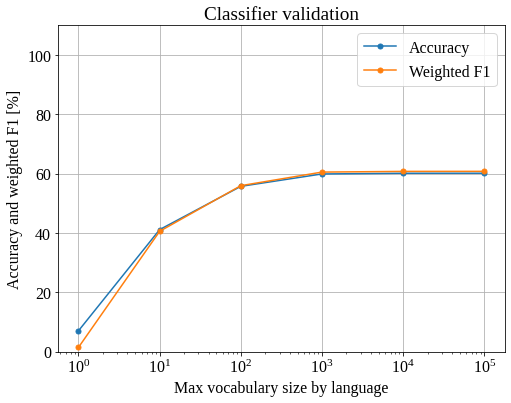

In [28]:
# Get prediction accuracy and weighted f1 for differect vocab sizes
n = 6
number_of_words = np.logspace(0, n-1, n, dtype=int)
accs = list()
f1s = list()
for n_words in tqdm(number_of_words):
    tfidf_ = { lang: top(tfidf[lang], n_words) for lang in tfidf }
    conf_mat = get_conf_mat(tfidf_)
    acc = np.diagonal(conf_mat).sum() / conf_mat.sum()
    accs.append(acc)
    f1s.append(f1(conf_mat))
plt.figure(figsize=(8, 6))
plt.plot(number_of_words, 100*np.array(accs), marker=".", ms=10, label="Accuracy")
plt.plot(number_of_words, 100*np.array(f1s), marker=".", ms=10, label="Weighted F1")
plt.xticks(number_of_words)
plt.ylim([0, 110])
plt.xscale("log")
plt.grid()
plt.title("Classifier validation")
plt.xlabel("Max vocabulary size by language")
plt.ylabel("Accuracy and weighted F1 [%]")
plt.legend()
with open(os.path.join("data", "accs_f1.json"), "w") as f:
    json.dump({
        "number_of_words": number_of_words.tolist(),
        "accs": accs,
        "f1s": f1s,
    }, f)

Given the results, we keep only the 10,000 highest scored words in each vocabulary.
At that size, the all vocabularies fill only a combined 5.5 MB, and the accuracy has converged.

The below confusion matrix shows the distribution of predictions vs true languages given the aforementioned vocabulary size limit.

In [29]:
# Only save for 10k vocab size, as more is redundant
tfidf = { lang: top(tfidf[lang], 10**4) for lang in tfidf }
with open(os.path.join("data", "tfidf.json"), "w", encoding="utf-8") as f:
    json.dump(tfidf, f)

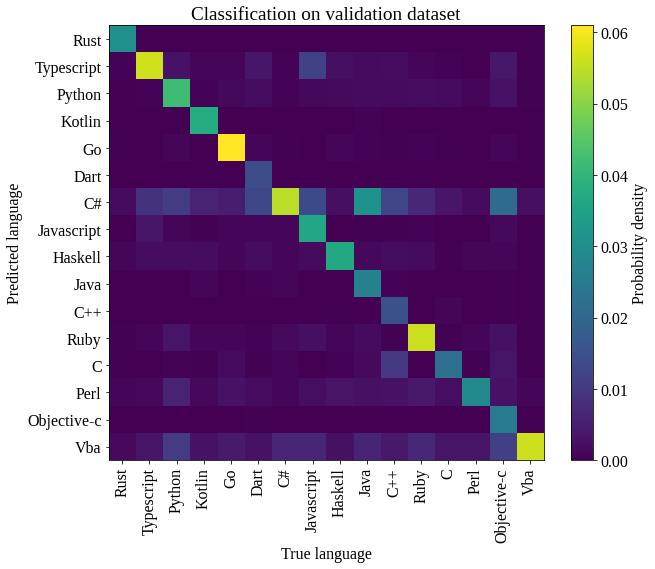

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
pos = ax.imshow(conf_mat/conf_mat.sum())
ax.set_xticks(range(len(loved_languages)))
ax.set_xticklabels([lang.capitalize() for lang in loved_languages])
ax.set_yticks(range(len(loved_languages)))
ax.set_yticklabels([lang.capitalize() for lang in loved_languages])
ax.set_title("Classification on validation dataset")
ax.set_xlabel("True language")
ax.set_ylabel("Predicted language")
ax.tick_params(axis="x", rotation=90)
bar = fig.colorbar(pos)
bar.set_label("Probability density")

The diagonal line representing correct predictions stands out as expected.
A large number of false predictions occur between similar languages such as TypeScript and JavaScript, which is to be expected.
These languages are both conceptually and syntactically similar, so it would make sense that the same words are important.

Most surprising is the fact that C# is so often predicted.
As a C-style language, it is quite close to a number of other languages, which could explain some of it.
Another partial explanation may be the "using" keyword, which doubles both as a C# keyword and a common word.
This would make a lot of text using that word get a high score for C#.
Indeed, using the interactive classifier on the <a href="https://asgerius.github.io/css-project">website</a> shows that any text including that word will often be classified as C#.
As shown below, only 0.05 percent of words in any language score higher than "using" for C#, which highlights a clear weakness of TF-IDF not using context.

In [4]:
all_scores = np.array([value for lang_scores in tfidf.values() for value in lang_scores.values()])
print("Percentile of 'using' score over all languages: %.2f %%" % (100 * (all_scores < tfidf["c#"]["using"])).mean())

Percentile of 'using' score over all languages: 99.95 %


### 3.4. Using the Classifier to Partition the Graph

Another way to determine how well the classifier works is within the context of the Stack Overflow graph.
This is done by classifying all nodes (which are authors) by all their submitted content.
Then the modularity is measured.

First a lookup table is constructed that maps users to all their submitted, cleaned content, which has been combined into a single string with different submissions being joined by spaces.

In [31]:
# Load TF-IDF scores
if "tfidf" not in locals():
    with open(os.path.join("data", "tfidf.json")) as f:
        tfidf = json.load(f)
# Load undirected graph
if "so_undirected_graph" not in locals():
    so_undirected_graph = nx.read_gpickle("so_undirected_graph.pkl")

# For every user, combine all their submissions into a single string
subs_by_user = dict()
for user_id, row in tqdm(so.groupby("owner/user_id"), total=len(set(so["owner/user_id"]))):
    subs_by_user[user_id] = " ".join(row.cclean.values)

100%|██████████| 227571/227571 [00:20<00:00, 11326.46it/s]


In [32]:
# Perform classifications and save in dict that maps user ids to classifications
classifications = { uid: classify(text)[0] for uid, text in tqdm(subs_by_user.items()) }

100%|██████████| 227571/227571 [03:05<00:00, 1224.96it/s]


In [33]:
partitions = [{n for n in so_undirected_graph.nodes if classifications[n] == l} for l in loved_languages]
print("Modularity using classifier partitions: %.4f" % nx.algorithms.community.modularity(so_undirected_graph, partitions))

Modularity using classifier partitions: 0.3852


While not as high as the 0.74 modularity achieved by using the true top languages for each user, this shows that the classifier still provides an effective way to detect communities within the SO graph with the modularity being several standard deviations from the mean modularity of the configuration models.

## 4. Discussion

#### What went well? 

In terms of the project scope, presented in the video, the ideas put forward were all followed up, and the Stack Overflow data was thoroughly investigated in terms of both network characteristics and sentiment.
The project further developed a classifier specifically designed for this data, and this performed at an acceptable level.

In terms of working as a group, everything went mostly smooth with no major problems arising.

#### What is still missing? What could be improved? Why? 

If the scope of the project was extended, here are some areas that could be explored:
 - In the sentiment analysis, comparisons with different sentiment packages (ie. other than VADER), could be made to more firmly asses the sentiment of Stack Overflow.
- The network could have had more investigation into communities/partitions, and more data should make for a more accurate investigation of Stack Overflow as a network.

    As we had to limit our data due to throttling and memory constraints, some edges may be missing. More data would help make sure our conclusions hold.
- The classifier's performance could potentially be further improved, and more effort could be put into checking that it generalizes to Stack Overflow data that the project did not focus on, other programming languages etc.

    One large area of potential improved is the use of context. As described, "using" was an example of a word being weighted to heavily when taken out of context, leading to many false predictions.